#  Вебинар 6. Двухуровневые модели рекомендаций
## Домашнее задание

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker
    - Вырос ли precision@5 при использовании двухуровневой модели?

---

In [ ]:
!pip install implicit==0.4.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 24.5 MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp38-cp38-linux_x86_64.whl size=3825503 sha256=d57a8a859a59e80935eb2c28d76cbf04b1bc3a3440b40835049b748ac9b505ab
  Stored in directory: /root/.cache/pip/wheels/00/ac/67/6f4536c819ed560c2c7e17c0f7a920e3e50c26108616087d05
Successfully built implicit


## Import libs

In [ ]:
import metrics
import recommenders
import utils

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix


# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Модель второго уровня
from lightgbm import LGBMClassifier

# # LightFM
# from lightfm import LightFM
# from lightfm.evaluation import precision_at_k, recall_at_k

# Libraries for working with paths and saving
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# from src.metrics import precision_at_k as custom_precision, recall_at_k
# from src.metrics import precision_at_k, recall_at_k
# from src.utils import prefilter_items
# from src.recommenders import MainRecommender

from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

## Read data

In [ ]:
# PATH_DATA = "../data"
PATH_DATA = "/content/drive/MyDrive/Colab Notebooks/21_рекомендательные_системы/data"

In [ ]:
# data = pd.read_csv(os.path.join(PATH_DATA,'retail_train.csv'))
# item_features = pd.read_csv(os.path.join(PATH_DATA,'product.csv'))
# user_features = pd.read_csv(os.path.join(PATH_DATA,'hh_demographic.csv'))

data = pd.read_csv(os.path.join(PATH_DATA,'retail_train.csv'))
item_features = pd.read_csv(os.path.join(PATH_DATA,'product.csv'))
user_features = pd.read_csv(os.path.join(PATH_DATA,'hh_demographic.csv'))

## Process features dataset

### Variables used

In [ ]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'
ACTUAL_COL = 'actual'

In [ ]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

## Split dataset for train, eval, test

In [ ]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [ ]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [ ]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [ ]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [ ]:
# выше видим разброс по пользователям и товарам

In [ ]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


## Prefilter items

In [ ]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


## Make cold-start to warm-start

In [ ]:
# ищем общих пользователей
common_users = list(set(data_train_matcher.user_id.values)&(set(data_val_matcher.user_id.values))&set(data_val_ranker.user_id.values))

data_train_matcher = data_train_matcher[data_train_matcher.user_id.isin(common_users)]
data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (422570, 13) Users: 1908 Items: 4997
val_matcher
Shape: (162896, 12) Users: 1908 Items: 27106
train_ranker
Shape: (162896, 12) Users: 1908 Items: 27106
val_ranker
Shape: (115735, 12) Users: 1908 Items: 24030


## Init/train recommender

In [ ]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4997 [00:00<?, ?it/s]

### Варианты, как получить кандидатов

Можно потом все эти варианты соединить в один

(!) Если модель рекомендует < N товаров, то рекомендации дополняются топ-популярными товарами до N

In [ ]:
# Берем тестового юзера 2375

In [ ]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1079023, 7166861, 844179, 947858]

In [ ]:
recommender.get_own_recommendations(2375, N=5)

[1079023, 918046, 847962, 950935, 1069531]

In [ ]:
recommender.get_similar_items_recommendation(2375, N=5)

[965766, 844179, 1070129, 828106, 1025535]

In [ ]:
recommender.get_similar_users_recommendation(2375, N=5)

[1092937, 994542, 1138596, 1129610, 1107760]

## Eval recall of matching

**Задание 1.**  
A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

In [ ]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."


In [ ]:
# N = Neighbors
N_PREDICT = 50 

In [ ]:
%%time
# для понятности расписано все в строчку, без функций, ваша задача уметь оборачивать все это в функции
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=50))

CPU times: user 32 s, sys: 22.2 s, total: 54.2 s
Wall time: 29.5 s


In [ ]:
%%time
# метрика считается очень долго и даёт маленький результат
# result_eval_matcher['sim_user_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 7.87 µs


#### Пускай, если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [ ]:
def get_own_and_top_rec(own_rec, top_rec, N):
    return (own_rec + list(set(top_rec) - set(own_rec)))[:N]

In [ ]:
result_eval_matcher.head(8)

,user_id,actual,own_rec,sim_item_rec,als_rec
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[9297615, 856942, 1072261, 1056402, 9655212, 9...","[1071244, 5582712, 994223, 1132231, 994223, 65...","[8090541, 856942, 1104349, 994223, 9297615, 11..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[948640, 923600, 13003092, 1138596, 1084036, 9...","[948650, 5569845, 878996, 863447, 819308, 8789...","[866871, 1098248, 896613, 919681, 1082185, 130..."
2,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[998519, 7147142, 939681, 6552318, 1074040, 94...","[1038985, 5565612, 1110042, 12731436, 5587656,...","[7147142, 1055168, 1060673, 851287, 9836526, 5..."
3,8,"[868075, 886787, 945611, 1005186, 1008787, 101...","[909269, 926808, 977927, 985605, 7409951, 9303...","[1044078, 5569845, 1100830, 916122, 5569374, 9...","[926808, 981660, 1058543, 7410361, 1034838, 71..."
4,9,"[883616, 1029743, 1039126, 1051323, 1082772, 1...","[872146, 985622, 9655676, 8066803, 9677424, 10...","[1110624, 862799, 1092120, 5568845, 1026209, 1...","[5568845, 5567502, 1056005, 1098910, 5570595, ..."
5,13,"[6544236, 822407, 908317, 1056775, 1066289, 11...","[965772, 10342382, 9488065, 10308337, 5567705,...","[999999, 6533965, 1070820, 10308337, 1043730, ...","[1015386, 10308337, 1133157, 9858920, 10342382..."
6,14,"[917277, 981760, 878234, 925514, 986394, 10220...","[902377, 1123106, 8090610, 874563, 829138, 872...","[999999, 1025611, 985999, 863762, 1028995, 104...","[1025611, 846823, 1127758, 910673, 1131344, 10..."
7,15,"[996016, 1014509, 1044404, 1087353, 976199, 10...","[1010051, 962777, 1091926, 1127548, 1044207, 8...","[882247, 999999, 970160, 1107173, 1038985, 103...","[1026118, 933637, 1086483, 1121656, 901666, 10..."


### Пример оборачивания

In [ ]:
# def evalRecall(df_result, target_col_name, recommend_model):
#     result_col_name = 'result'
#     df_result[result_col_name] = df_result[target_col_name].apply(lambda x: recommend_model(x, N=25))
#     return df_result.apply(lambda row: recall_at_k(row[result_col_name], row[ACTUAL_COL], k=N_PREDICT), axis=1).mean()

In [ ]:
# evalRecall(result_eval_matcher, USER_COL, recommender.get_own_recommendations)

In [ ]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [ ]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

### Recall@50 of matching

In [ ]:
TOPK_RECALL = 50

In [ ]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.044964824351188704),
 ('als_rec', 0.038272367777569316),
 ('sim_item_rec', 0.03254957303992165)]

### Precision@5 of matching

In [ ]:
TOPK_PRECISION = 5

In [ ]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('als_rec', 0.12190775681341719),
 ('own_rec', 0.1190775681341719),
 ('sim_item_rec', 0.06551362683438156)]

Дают ли own recommendtions + top-popular лучший recall?   

**В нашем случае ДА**  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}


In [ ]:
%%time

K = [20, 50, 100, 200, 500]

als_rec_at_k  = [(result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=k)), k) for k in K]

als_recall_at_k = [(np.array([recall_at_k(rec[0][i], result_eval_matcher[ACTUAL_COL][i], k=rec[1]) for i in result_eval_matcher.index]).mean(), rec[1]) for rec in als_rec_at_k]

als_recall_at_k

CPU times: user 58.8 s, sys: 49.6 s, total: 1min 48s
Wall time: 56.3 s


[(0.023099897792504917, 20),
 (0.038272367777569316, 50),
 (0.05405121395522017, 100),
 (0.0759957123043037, 200),
 (0.11690286037001144, 500)]

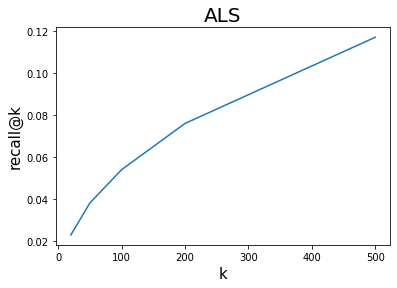

In [ ]:
plt.plot(K, list(map(lambda x: x[0], als_recall_at_k)))
plt.title('ALS', fontsize=20)
plt.xlabel('k', fontsize=15)
plt.ylabel('recall@k', fontsize=15)
plt.show()

C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?  

Чем больше k, чем больше потенциальных товаров (кандидатов) мы отбираем, тем модель второго уровня порекомендует точнее, но это будет дольше, так как количетво данных возрастёт до n * k, где n, это количетсво пользователей для которых мы рекомендуем, с учётом горячего старта 1908 пользователей.

Число k подбирается с учётом возможностей по мощности и времени ожидания.

Оптимальное число k находится на перегибе графика recall@k(k), там где стремительный рост recall@k снижается. В нашем случае за перегиб можно взять точку k=200.

In [ ]:
N_PREDICT = 200

## Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах

## Подготовка данных для трейна

In [ ]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [ ]:
# собираем кандитатов с первого этапа (matcher)
# df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

In [ ]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1030182, 950202, 969725, 1011457, 85..."
1,2021,"[950935, 1119454, 9419961, 870614, 978751, 939..."


In [ ]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = ITEM_COL

In [ ]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [ ]:
df_match_candidates.head(4)

,user_id,item_id
0,2070,1105426
0,2070,1030182
0,2070,950202
0,2070,969725


### Check warm start

In [ ]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (381600, 2) Users: 1908 Items: 4990


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [ ]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

In [ ]:
df_ranker_train.head()

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


#### Не хватает нулей в датасете, поэтому добавляем наших кандитатов в качество нулей

In [ ]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

In [ ]:
df_ranker_train.target.value_counts()

0.0    370902
1.0     10698
Name: target, dtype: int64

In [ ]:
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1030182,0.0


In [ ]:
df_ranker_train['target'].mean()

0.028034591194968553

## Подготавливаем фичи для обучения модели

**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее кол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

### user

In [ ]:
# user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [ ]:
df_ranker_train[~df_ranker_train['user_id'].isin(user_features.user_id)].shape[0]

229800

In [ ]:
df_ranker_train['user_id'].shape[0]

381600

In [ ]:
df_ranker_train[~df_ranker_train['user_id'].isin(user_features.user_id)].shape[0] / df_ranker_train['user_id'].shape[0] * 100

60.22012578616353

Отсутствуют данные о 60% пользователей, по этому мы не будем использовать user_features который нам дан, но сделаем небольшой свой на основе имеющихся данных из data.

Средний чек

In [ ]:
average_check = (data_train_ranker.groupby([USER_COL])['sales_value'].sum() 
                                  / data_train_ranker.groupby([USER_COL])['basket_id'].nunique()).reset_index()

average_check.columns=[USER_COL, 'average_check']

user_features = average_check.copy()

Количество покупок в месяц

In [ ]:
user_per_month = (data_train_ranker.groupby([USER_COL])['basket_id'].nunique() 
                                                  / ((VAL_MATCHER_WEEKS*7) / (365/12))).reset_index()

user_per_month.columns=[USER_COL, 'user_per_month']

user_features = user_features.merge(user_per_month, on=USER_COL, how='left')

In [ ]:
user_features.head(2)

,user_id,average_check,user_per_month
0,1,48.825714,5.069444
1,6,20.562500,11.587302


### item

In [ ]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


Количество покупок в неделю

In [ ]:
item_per_week = (data_train_ranker.groupby([ITEM_COL])['quantity'].sum() / 6).reset_index()

item_per_week.columns=[ITEM_COL, 'item_per_week']

item_features = item_features.merge(item_per_week, on=ITEM_COL, how='left')

item_features.item_per_week.fillna(0, inplace=True)

Цена

In [ ]:
data_price = data[data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS)] 

data_price['price'] = data_price['sales_value'] / data_price['quantity']

price = (data_price.groupby([ITEM_COL])['price'].first()).reset_index()

item_features = item_features.merge(price, on=ITEM_COL, how='left')

<ipython-input-63-4a0e449c924e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_price['price'] = data_price['sales_value'] / data_price['quantity']


In [ ]:
item_features.price.fillna(item_features.price.median(), inplace=True)

In [ ]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,item_per_week,price
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,0.0,3.49
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,0.0,0.99


### user-item

In [ ]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

In [ ]:
df_ranker_train.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,item_per_week,price,average_check,user_per_month
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,0.833333,3.99,14.355581,31.140873
1,2070,1030182,0.0,1075,GROCERY,National,COOKIES/CONES,FRUIT FILLED COOKIES,16 OZ,0.833333,3.00,14.355581,31.140873
2,2070,950202,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,1.166667,3.99,14.355581,31.140873


In [ ]:
df_ranker_train.isna().sum().sum()

0

Пропусков нету, это отлично!

In [ ]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [ ]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'item_per_week',
 'price',
 'average_check',
 'user_per_month']

## Обучение модели ранжирования

In [ ]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=8,
                     n_estimators=300,
                     learning_rate=0.05,
                     categorical_column=cat_feats)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [ ]:
df_ranker_predict = df_ranker_train.copy()

In [ ]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [ ]:
df_ranker_predict.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,item_per_week,price,average_check,user_per_month,proba_item_purchase
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,0.833333,3.99,14.355581,31.140873,0.009120
1,2070,1030182,0.0,1075,GROCERY,National,COOKIES/CONES,FRUIT FILLED COOKIES,16 OZ,0.833333,3.00,14.355581,31.140873,0.008845
2,2070,950202,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,1.166667,3.99,14.355581,31.140873,0.011619
3,2070,969725,0.0,69,SEAFOOD-PCKGD,Private,SEAFOOD - FROZEN,SEAFOOD-FRZ-IQF COOKED SHRIMP,17 OZ,2.166667,7.99,14.355581,31.140873,0.025462
4,2070,1011457,0.0,5143,DRUG GM,National,GREETING CARDS/WRAP/PARTY SPLY,CARDS EVERYDAY,,3.166667,3.86,14.355581,31.140873,0.013427


In [ ]:
df_ranker_predict.shape

(381600, 14)

In [ ]:
df_ranker_predict.loc[df_ranker_predict[USER_COL]==2070].sort_values('proba_item_purchase', ascending=False)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,item_per_week,price,average_check,user_per_month,proba_item_purchase
129,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,203.333333,2.49,14.355581,31.140873,0.322070
73,2070,10149640,1.0,1011,GROCERY,National,BATH TISSUES,TOILET TISSUE,,10.166667,5.99,14.355581,31.140873,0.319015
113,2070,859075,1.0,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ,55.166667,1.67,14.355581,31.140873,0.206110
23,2070,916993,1.0,69,GROCERY,Private,MILK BY-PRODUCTS,COTTAGE CHEESE,24 OZ,8.333333,1.99,14.355581,31.140873,0.191211
117,2070,983584,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,CHOCOLATE MILK,1 GA,26.500000,2.32,14.355581,31.140873,0.139551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,2070,12456474,0.0,693,DRUG GM,National,CANDY - PACKAGED,CANDY BAGS-CHOCOCLATE,11 OZ,0.000000,2.50,14.355581,31.140873,0.000123
9,2070,846502,0.0,693,DRUG GM,National,CANDY - PACKAGED,CANDY BAGS-CHOCOCLATE,12 OZ,0.000000,3.19,14.355581,31.140873,0.000123
110,2070,841686,0.0,544,GROCERY,National,BAG SNACKS,MISC BAG SNACKS,7 OZ,0.000000,2.49,14.355581,31.140873,0.000112
85,2070,944354,0.0,5143,DRUG GM,National,GREETING CARDS/WRAP/PARTY SPLY,CARDS EVERYDAY,,0.000000,2.49,14.355581,31.140873,0.000111


- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

# Evaluation on test dataset

In [ ]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


## Eval matching on test dataset

In [ ]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_ranker['als_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

CPU times: user 3.04 s, sys: 34.6 ms, total: 3.07 s
Wall time: 3.07 s


In [ ]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('als_rec', 0.09727463312368974), ('own_rec', 0.0960167714884696)]

## Eval re-ranked matched result on test dataset
    Вспомним df_match_candidates сет, который был получен own_recommendations на юзерах, набор пользователей мы фиксировали и он одинаков, значи и прогноз одинаков, поэтому мы можем использовать этот датафрейм для переранжирования.
    

In [ ]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [ ]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [ ]:
result_eval_ranker.head()

,user_id,actual,own_rec,als_rec,reranked_own_rec
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[9297615, 856942, 1072261, 1056402, 9655212, 9...","[8090541, 856942, 1104349, 994223, 9297615, 11...","[1070820, 10149640, 1022254, 9655212, 1082212]"
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[948640, 923600, 13003092, 1138596, 1084036, 9...","[866871, 1098248, 896613, 919681, 1082185, 130...","[1082185, 1098844, 9835606, 862866, 916122]"
2,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[998519, 7147142, 939681, 6552318, 1074040, 94...","[7147142, 1055168, 1060673, 851287, 9836526, 5...","[1126899, 866211, 1055504, 1122358, 8090537]"
3,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[909269, 926808, 977927, 985605, 7409951, 9303...","[926808, 981660, 1058543, 7410361, 1034838, 71...","[1106523, 5569230, 5569471, 857503, 1044188]"
4,9,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[872146, 985622, 9655676, 8066803, 9677424, 10...","[5568845, 5567502, 1056005, 1098910, 5570595, ...","[883616, 1056005, 1004001, 1044078, 862799]"


In [ ]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.17410901467505244)
('als_rec', 0.09727463312368974)
('own_rec', 0.0960167714884696)


- Вырос ли precision@5 при использовании двухуровневой модели?  

**ДА**